In [1]:
%load_ext autoreload
%autoreload 2

import batman
import gpjax as gpx
import jax.numpy as jnp
from jax import jit
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from gpjax.kernels import RBF, Constant, Linear, Periodic, PoweredExponential

from kernels import OrnsteinUhlenbeck, ProductKernel, SumKernel
from kernelsearch import KernelSearch

import emcee

rng = np.random.default_rng(seed=42)

In [2]:
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

In [3]:
def calculate_lightcurve(t, params):
    param_container = batman.TransitParams()
    param_container.t0 = params[0]  # time of inferior conjunction
    param_container.per = 1.0  # orbital period
    param_container.rp = params[1]  # planet radius (in units of stellar radii)
    param_container.a = params[2]  # semi-major axis (in units of stellar radii)
    param_container.inc = 87.0  # orbital inclination (in degrees)
    param_container.ecc = 0.0  # eccentricity
    param_container.w = 90.0  # longitude of periastron (in degrees)
    param_container.u = [params[3], params[4]]  # limb darkening coefficients [u1, u2]
    param_container.limb_dark = "quadratic"  # limb darkening model

    m = batman.TransitModel(param_container, t)  # initializes model
    return m.light_curve(param_container)

In [4]:
t = np.linspace(-0.05, 0.08, 1000)
true_lightcurve = calculate_lightcurve(
    t=t,
    params=[0, 0.1, 15, 0.1, 0.3],
)

In [14]:
test_ind = np.sort(rng.choice(len(t), 150))
t_train = t[test_ind]
lc_latent = (
    true_lightcurve
    - 0.05 * np.cos(200 * t / (2 * np.pi))
    + 0.08 * (((t - 0.01) / t[-1]) ** 2) * np.sin(4000 * t / (2 * np.pi))
)
lc_train = lc_latent[test_ind]  # + rng.normal(scale=0.005, size=len(test_ind))

In [6]:
mask = ~np.ma.masked_where((-0.01 < t_train) & (t_train < 0.01), t_train).mask

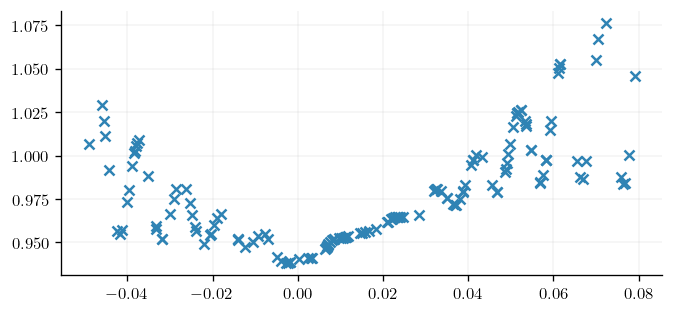

In [7]:
# plt.plot(t, true_lightcurve)
plt.scatter(t_train, lc_train)

In [8]:
from kernelsearch import KernelSearch
from kernels import OrnsteinUhlenbeck
from gpjax.kernels import RBF, Linear, Periodic, PoweredExponential

In [9]:
kernel_library = [
    Linear(),
    RBF(),
    OrnsteinUhlenbeck(),
    Periodic(),
    # PoweredExponential(power=jnp.array(0.5)),
]  # default powered exponential has infinite parameter for some reason

In [10]:
tree = KernelSearch(
    kernel_library,
    X=jnp.array(t_train[mask]),
    y=jnp.array(lc_train[mask]),
    obs_stddev=0.005,
    verbosity=1,
)

model = tree.search(
    depth=7,
    n_leafs=3,
    patience=1,
)

Fitting Layer 1: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


Layer 1 || Current AICs: [Array(-789.37253656, dtype=float64, weak_type=True), Array(374.76840245, dtype=float64, weak_type=True), Array(375.39717786, dtype=float64, weak_type=True), Array(3664363.38775779, dtype=float64, weak_type=True)]


Fitting Layer 2: 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Layer 2 || Current AICs: [Array(-972.85627914, dtype=float64, weak_type=True), Array(-781.37253656, dtype=float64, weak_type=True), Array(-781.37253656, dtype=float64, weak_type=True), Array(-781.37253656, dtype=float64, weak_type=True), Array(-781.37253243, dtype=float64, weak_type=True), Array(-780.28441253, dtype=float64, weak_type=True), Array(-779.25095933, dtype=float64, weak_type=True), Array(-777.37253656, dtype=float64, weak_type=True), Array(-777.37253656, dtype=float64, weak_type=True), Array(-777.37253634, dtype=float64, weak_type=True), Array(-775.25095987, dtype=float64, weak_type=True), Array(-773.37253917, dtype=float64, weak_type=True), Array(-760.77706422, dtype=float64, weak_type=True), Array(-756.77706397, dtype=float64, weak_type=True), Array(-238.15432092, dtype=float64, weak_type=True), Array(377.71408385, dtype=float64, weak_type=True), Array(377.71408387, dtype=float64, weak_type=True), Array(381.18118343, dtype=float64, weak_type=True), Array(381.71408387, dty

Fitting Layer 3: 100%|██████████| 28/28 [00:51<00:00,  1.85s/it]


Layer 3 || Current AICs: [Array(-960.85627914, dtype=float64, weak_type=True), Array(-960.85627914, dtype=float64, weak_type=True), Array(-960.8562791, dtype=float64, weak_type=True), Array(-959.028577, dtype=float64, weak_type=True), Array(-956.85627914, dtype=float64, weak_type=True), Array(-956.85627912, dtype=float64, weak_type=True), Array(-955.028577, dtype=float64, weak_type=True), Array(-779.37253656, dtype=float64, weak_type=True), Array(-773.37253656, dtype=float64, weak_type=True), Array(-773.37253656, dtype=float64, weak_type=True), Array(-771.37253656, dtype=float64, weak_type=True), Array(-771.37253656, dtype=float64, weak_type=True), Array(-771.37253656, dtype=float64, weak_type=True), Array(-771.37253655, dtype=float64, weak_type=True), Array(-771.37253527, dtype=float64, weak_type=True), Array(-771.37253275, dtype=float64, weak_type=True), Array(-770.28441253, dtype=float64, weak_type=True), Array(-770.28441253, dtype=float64, weak_type=True), Array(-767.37253656, dtyp

Fitting Layer 4: 100%|██████████| 28/28 [01:50<00:00,  3.94s/it]

Layer 4 || Current AICs: [Array(-958.85627914, dtype=float64, weak_type=True), Array(-952.85627914, dtype=float64, weak_type=True), Array(-952.8562791, dtype=float64, weak_type=True), Array(-946.85627914, dtype=float64, weak_type=True), Array(-938.85627914, dtype=float64, weak_type=True), Array(-938.85627914, dtype=float64, weak_type=True), Array(-938.85627914, dtype=float64, weak_type=True), Array(-938.85627913, dtype=float64, weak_type=True), Array(-938.8562791, dtype=float64, weak_type=True), Array(-938.8562791, dtype=float64, weak_type=True), Array(-938.8562791, dtype=float64, weak_type=True), Array(-938.85627907, dtype=float64, weak_type=True), Array(-938.85627907, dtype=float64, weak_type=True), Array(-937.02857699, dtype=float64, weak_type=True), Array(-937.02857699, dtype=float64, weak_type=True), Array(-937.02857691, dtype=float64, weak_type=True), Array(-934.85627914, dtype=float64, weak_type=True), Array(-934.85627914, dtype=float64, weak_type=True), Array(-934.85627912, dty

In [11]:
tree._kernel_name(model.prior.kernel)

'Periodic * RBF'

In [12]:
latent_dist = model.predict(t.reshape(-1, 1), train_data=tree.data)
predictive_dist = model.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

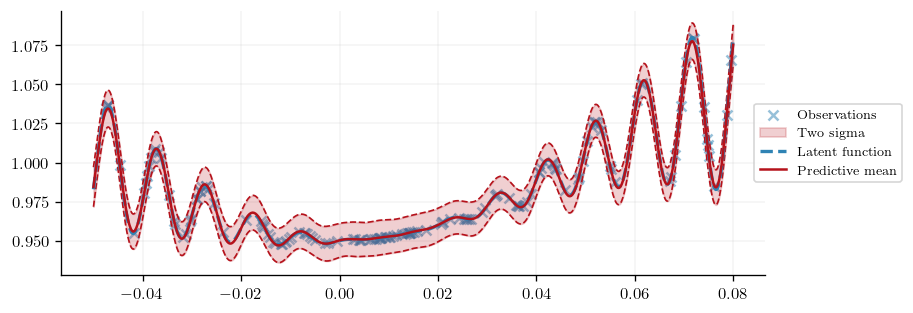

In [15]:
fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.scatter(t_train, lc_train, label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    t,
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    t,
    predictive_mean - 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    t,
    predictive_mean + 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    t,
    lc_latent,
    label="Latent function",
    color=cols[0],
    linestyle="--",
    linewidth=2,
)
ax.plot(t, predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))

In [ ]:
from jax.flatten_util import ravel_pytree
from jax.tree_util import tree_map
from gpjax.base import meta_map

ravel_pytree(model)

(Array([5.00000000e-03, 7.07717848e+00, 1.04834449e+00], dtype=float64),
 <jax._src.util.HashablePartial at 0x7f92a7f6c730>)

In [ ]:
def meta_map(
    f: Callable[[Any, Dict[str, Any]], Any],
    pytree: Union[Module, Any],
    *rest: Any,
    is_leaf: Optional[Callable[[Any], bool]] = None,
) -> Union[Module, Any]:
    """Apply a function to a Module where the first argument are the pytree leaves, and the second argument are the Module metadata leaves.
    Args:
        f (Callable[[Any, Dict[str, Any]], Any]): The function to apply to the pytree.
        pytree (Module): The pytree to apply the function to.
        rest (Any, optional): Additional pytrees to apply the function to. Defaults to None.
        is_leaf (Callable[[Any], bool], optional): predicate to determine if a node is a leaf. Defaults to None.

    Returns
    -------
        Module: The transformed pytree.
    """
    leaves, treedef = meta_flatten(pytree, is_leaf=is_leaf)
    all_leaves = [leaves] + [treedef.treedef.flatten_up_to(r) for r in rest]
    return treedef.unflatten(f(*xs) for xs in zip(*all_leaves, strict=True))


def update_trainables(meta_leaf):
    meta, leaf = meta_leaf
    if meta.get("trainable", True):
        return 2
    else:
        return leaf


model_with_params = meta_map(update_trainables, model)